In [59]:
import gensim
import subprocess
import re
import numpy as np
import time
import nltk
import os
import json
import collections
import time
import matplotlib.pyplot as plt
import itertools
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/kirov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/kirov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Problema: Determinar la veracidad de tweets, utilizando clasificación
- Implementar un clasificador de post de tweets para validar su veracidad.
- Para esto se utilizará redes neuronales y el árbol de  propagación de los tweets.


In [60]:
#Image("/home/eprovidel/Text_Mining/Proyecto/modelos.png")

In [61]:
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)

# Parte 1: Procesamiento de datos y funcionalidades

## Parte 1.1: Cargar tweets para generar datos de entrenamiento

In [62]:
words_not_in_model = list()
def computeDocumentAWE(docText, _model, _model_vocab, _emb_size):
    """
    Calcula el AWE del texto recibido en el parámetro docText.
    La variable docSum almacena la suma de los embeddings de cada
    palabra w en docText. Luego esta suma se divide por el total
    de n palabras consideradas.
    
    Se considero una palabra para el cálculo sólo si esta pertenece
    al vocabulario del modelo. Si no, no es considerada en la suma 
    ni tampoco en el calculo de n.
    """    
    docSum = np.zeros(_emb_size)
    n = 0
    
    ####
    ## AWE = 1/n * Sum w_embedding, para cada w en docText
    ####
    
    normalizedDocText = normalizarTexto(docText)
    
    for w in normalizedDocText:
        ## Se descartan palabras que no están en el modelo de embeddings (vocabulario)
        if w in _model_vocab:
            n = n + 1
            w_embedding = _model[w]
            docSum = docSum + w_embedding
        else:
            words_not_in_model.append(w)

    return docSum / n if n > 0 else docSum    

In [63]:
def normalizarTexto(docText):
    # En gensim.utils, pasa a minúsculas, descarta palabras muy grandes o muy pequeñas.
    return simple_preprocess(docText)

In [64]:
def parseTwitterTree(tree_file):
    tree_data = list()
    for line in tree_file:
        _, second_part = line.split('->')
        second_part = second_part.rstrip()
        second_part = second_part.replace("'", "\"")
        tree_data.append(json.loads(second_part))     
    return tree_data

In [65]:
### Obtener diccionario con todos los posts
all_posts = {}
all_text = {}
#for file in os.listdir('/home/kirov/dataset/post'):
for file in os.listdir('./post'):    
    if file.endswith(".json"):        
        try:        
            with open(os.path.join('./post', file), 'r') as f:
                tweet_id  = os.path.splitext(file)[0]
                tweet_dic = json.load(f)
                all_posts[tweet_id] = tweet_dic
                

        except:
            pass
        

### Obtener ids de tweets etiquetados
labels = {}
with open('label.txt') as label_f:
    for label_line in label_f:
        
        label, tweet_id = label_line.split(':')
        tweet_id = tweet_id.rstrip()
        labels[tweet_id] = label

print("Tweets etiquetados      : ", len(labels))        

seqs_lens = []
labeled_posts = {}
number_of_tweets = 0
number_of_retweets = 0
number_of_invalid_tweets = 0
no_in_data = 0
for tweet_id in labels.keys():
    try:
        if tweet_id in all_posts:
            tree_path = os.path.join('./tree', tweet_id + '.txt')
            with open(tree_path) as tree_file:
                tree_data = parseTwitterTree(tree_file)
                ### Remover retweets                
                first = tree_data[0]
                without_rt = list(filter(lambda t: t[1] != tweet_id, tree_data))
                number_of_retweets = number_of_retweets + (len(tree_data) - len(without_rt))
                only_valid = list(filter(lambda t: t[1] in all_posts, without_rt))
                number_of_invalid_tweets = number_of_invalid_tweets + (len(without_rt) - len(only_valid))
                seqs_lens.append(len(only_valid))
                labeled_posts[tweet_id] = (labels[tweet_id], [first] + only_valid)
                number_of_tweets = number_of_tweets + 1 
        else:
             no_in_data = no_in_data + 1 
        
    except Exception as e:
        print(e)             
        
        
print("no_in_data              : ", no_in_data) ## están etiquetados, pero no en los post
print("number_of_tweets        : ", number_of_tweets)        
print("all_posts               : ", len(all_posts))
print("number_of_retweets      : ", number_of_retweets) ## En árbol de propagación
print("number_of_invalid_tweets: ", number_of_invalid_tweets) ## En árbol de propagación


Tweets etiquetados      :  818
no_in_data              :  65
number_of_tweets        :  753
all_posts               :  21741
number_of_retweets      :  297301
number_of_invalid_tweets:  6432


**Importante:** Importan sólo los datos etiquetados que se conocen y que no son retweets de cada árbol de progación.

## Parte 1.2: Aplicar AWE a cada tweet del arbol

In [66]:
## Cada palabra tiene un embedding que viene del modelo
## Se calcula AWE para cada post del árbol de propagación (lista de propagación que el primer elemento es el tweet original)
def computeTreeAWE(tree, _model, _model_vocab, _emb_size):
    return list(map(lambda t: [t[0], computeDocumentAWE(all_posts[t[1]]['text'],
                                                        _model, _model_vocab, _emb_size), t[2]], tree))

[17 19 33 23 28 32 22 22 22 22 16 17 15 18 22 15 19 16 21 11  9  8 10 14
  7  9  6  7  8  7 11  6  7  5  5 10  2  3  5  5  1  7  3  7  3  1  3  7
  4  5  2  3  5  1  1  4  1  4  5  0  3  0  1  4  2  3  4  2  1  2  1  1
  4  2  2  4  1  1  5  1  2  2  1  1  1  3  3  0  3  1  1  2  1  2  2  0
  1  1  1  1  0  0  1  0  1  1  0  1  2  1  1  0  0  1  0  1  0  1  0  0
  0  1  1  1  2  0  0  1  0  2  1  1  0  0  1  1  0  0  1  0  0  0  0  0
  1  0  1  0  1  0  0  0  0  0  1  1  0  0  2  1  0  0  1  1  1  0  0  0
  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0
  0  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
  0  0  0  0  0  0  0  0  1  0  0  0  1  1  0  0  1  0  0  0  0  0  0  1
  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

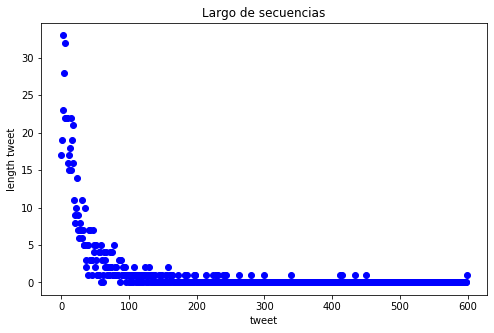

In [67]:
# Categorias: true, false, unverified, non-rumor
categories = ['true', 'false', 'unverified', 'non-rumor']
num_categories = len(categories)

#entrega un vector one-hot de la categoria, de largo 4 (por el número de categorias)
def to_category_vector(category):
    vector = np.zeros(len(categories)).astype(np.float32)
    
    for i in range(len(categories)):
        if categories[i] == category:
            vector[i] = 1.0
            break
    
    return vector

#La red neuronal necesita un tamaño fijo para la secuencia (datos de entrada)
#¿Que largo de secuencia utilizar?
counts = np.bincount(seqs_lens) ## seqs_len sólo de los 753
print(counts)
mode_seq_len = np.argmax(counts)
mean_seq_len = int(np.mean(seqs_lens))
min__seq_len = min(seqs_lens)
max__seq_len = max(seqs_lens) 
## luego se hace padding

print("seqs_lens   : ", seqs_lens)
print("min__seq_len: ", min__seq_len)
print("max__seq_len: ", max__seq_len)
print("mean_seq_len: ", mean_seq_len)
print("mode_seq_len: ", mode_seq_len )

plt.close('all')
plt.figure(figsize=(8,5))
plt.plot(counts,'bo')
plt.title("Largo de secuencias")
plt.xlabel("tweet")
plt.ylabel("length tweet")
plt.savefig('/home/kirov/plots/plt_largoSecuenciasGRU')

tree_max_num_seq = mean_seq_len

In [68]:
## padding al final, con empty
def padAWE(empty, max_num, seq):
    from itertools import repeat
    seq.extend(repeat(empty, max_num - len(seq)))
    return seq

In [69]:
## 
def generate_w2v_variant(_model, _model_vocab, _emb_size):
    
    empty_awe = np.zeros(_emb_size)
    ## Calcula AWE de cada árbol
    labeled_posts_awe = { k: (v[0], computeTreeAWE(v[1], _model, _model_vocab, _emb_size)) for k, v in labeled_posts.items() }
    ## Realiza padding a las secuencias
    padded_labeled_posts_awe = {k: (v[0], padAWE(empty_awe, tree_max_num_seq, v[1])) for k, v in labeled_posts_awe.items()}

    #Genera los datos X e Y para alimentar el modelo de red neuronal
    #Inicialmente con ceros y con la forma adecuada.
    X = np.zeros(shape=(number_of_tweets, tree_max_num_seq, _emb_size)).astype(np.float32)
    Y = np.zeros(shape=(number_of_tweets, num_categories)).astype(np.float32)

    # Asigna al vector X los datos correspondientes
    for idx, (tweet_id, tweet_data) in enumerate(list(padded_labeled_posts_awe.items())):
        for jdx, tweet_d in enumerate(tweet_data[1]):
            ### tweet_d = [uid, tweet_awe, time]
            if jdx == tree_max_num_seq:
                break            
            else:            
                X[idx, jdx, :] = tweet_d[1]

    # Asigna al vector Y los datos correspondientes            
    for idx, (tweet_id, tweet_data) in enumerate(list(padded_labeled_posts_awe.items())):
        Y[idx, :] = to_category_vector(tweet_data[0])

    print(np.shape(X))
    print(np.shape(Y))
    return X, Y

## Parte 1.3: Modelo stacked LSTM

In [70]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, GRU


### tensorflow OMP: Error #15
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


def create_model_StackedLSTM(
        _emb_size,
        _num_categories,
        _units = 200,
        _dropout = 0.3):
    
    model = Sequential()
    model.add(LSTM(_units, input_shape=(tree_max_num_seq, _emb_size), return_sequences=True))
    model.add(LSTM(_units, return_sequences=False))        
    model.add(Dropout(_dropout))
    model.add(Dense(_num_categories))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model



## Parte 1.4: Funciones para graficar

In [71]:
def graphic_data(dataX, dataY, labels, title, x_label, y_label, x_min, y_min, x_max, y_max=0):
    plt.close('all') 
    plt.title(title)
    for d in dataY:
        plt.ylim(y_min,y_max)
        plt.xlim(x_min,x_max)
        plt.plot(d)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(dataX)
    plt.legend(labels, loc='upper right')
    plt.savefig('/home/kirov/plots/plt_grapicDataLSTMstacked')
    plt.show()

In [72]:
#ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/home/kirov/plots/plt_matrizLSTMstacked')

In [73]:
def plot_conf_matrix(y_true, y_pred, _title):
    y_t = y_true.argmax(1)#Yw2v50_full.argmax(1)
    y_p = y_pred.argmax(1)#Yw2v50_predict.argmax(1)
    conf_matrix = confusion_matrix(y_t, y_p)
    class_names = ['true', 'false', 'unverified', 'non-rumor']
    # Plot confusion matrix
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False,
                      title=_title,cmap=plt.cm.Greens) 

## Parte 1.5: Entrenamiento y Pruebas

In [74]:
epochs = 50 #200
units_final = [128,256] #[8,16, 32, 64, 128, 256, 512, 1024]

In [75]:
#dummy_model = create_model_LSTM(10, 128)
#dummy_model = create_model_GRU(10,10,128)
#dummy_model.summary()

In [76]:
def perform_kfold_validation(X, Y, _emb_size, k = 5, _verbose = 0):
    seed = 7
    results_score = []
    results_acc   = []
    results_time  = []
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    y_pred = []

    for j, (train_idx, test_idx) in enumerate(kfold.split(X, Y.argmax(1))):
        print('\nFold ',j)
        print("\nlen train index: %s" % len(train_idx))       
        print("len test index: %s" % len(test_idx))
        X_train_cv = X[train_idx]
        Y_train_cv = Y[train_idx]
        X_test_cv  = X[test_idx]
        Y_test_cv  = Y[test_idx]
        
        #crear modelo LSTM stacked
        
        model = create_model_StackedLSTM(_emb_size,num_categories)
     
        start_time = time.time()
        model.fit(X_train_cv, Y_train_cv, batch_size=128, epochs=200, verbose= _verbose)     ## entrenamos
        score, acc = model.evaluate(X_test_cv, Y_test_cv, batch_size=128,verbose= _verbose) ## evaluamos /acc: accuracy
        end_time = time.time()

        print('Score: %1.4f' % score)
        print('Accuracy: %1.4f' % acc)  
        print('time: %1.4f' % (end_time - start_time))
        results_score.append(score)
        results_acc.append(acc)
        results_time.append((end_time - start_time))
    
    return results_score, results_acc, results_time

In [77]:
### https://datascience.stackexchange.com/questions/20413/clarification-on-the-keras-recurrent-unit-cell
def perform_final_validation(X, Y, X_validate, Y_validate, _emb_size, units=[8,16, 32, 64, 128, 200], _epochs=200, _verbose=1):
    h_units_score = []
    h_units_acc   = []
    history = []
    all_models = []
    for unit_size in (units): #[8,16, 32, 64, 128, 200, 512, 1024]
        print("########################")
        print("## UNIT SIZE ", unit_size)
        
        #crear modelo final LSTM stacked
        
        final_model = create_model_StackedLSTM(_emb_size,num_categories,_units = unit_size)

        
        final_model.summary()
        
        history.append(final_model.fit(X, Y, batch_size=128, epochs=_epochs, verbose=_verbose))
        score, acc = final_model.evaluate(X_validate, Y_validate, batch_size=128)
        h_units_score.append(score)
        h_units_acc.append(acc)
        all_models.append(final_model)
    return h_units_score, h_units_acc,history, all_models

## Parte 2: Modelo LSTM

### Modelo word2vec específico, LSTM

### Creando los vectores
Se utilizan todos los tweets etiquetados como el universo de documentos, para crear el modelo de embedding w2v

In [78]:
# build vocabulary and train model
w2v50_emb_size = 50
WINDOW = 5
W2V_EPOCHS = 50
BATCH_SIZE = 128

documents = []
for k, v in labeled_posts.items():
    for t in v[1]:
        #print(t[1]) ## sera porque algunos text estan vacios????
        # Dejar todo en lowercase
        documents.append(simple_preprocess(all_posts[t[1]]['text']))

In [79]:

w2v50_model = gensim.models.word2vec.Word2Vec(
 documents,
 size=w2v50_emb_size,
 window=WINDOW,
 min_count=2,
 workers=4,
 iter=W2V_EPOCHS
)

#Train model
w2v50_model.train(documents, total_examples=len(documents), epochs=w2v50_model.epochs)

(14799840, 18536800)

In [80]:
w2v50_model_vocab = w2v50_model.wv.vocab

In [81]:
Xw2v50_full, Yw2v50_full = generate_w2v_variant(w2v50_model, w2v50_model_vocab, w2v50_emb_size)
Xw2v50, X_1w2v50, Yw2v50, Y_1w2v50 = train_test_split(Xw2v50_full, Yw2v50_full, test_size=0.15)
perform_kfold_validation(Xw2v50, Yw2v50, w2v50_emb_size)
#perform_final_validation(Xw2v50, Yw2v50, X_1, Y_1, w2v50_emb_size) #X_1 y Y_1 Es el tamaño del set de testing
perform_final_validation(Xw2v50, Yw2v50, X_1w2v50, Y_1w2v50, w2v50_emb_size)

/home/kirov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(753, 36, 50)
(753, 4)

Fold  0

len train index: 512
len test index: 128

Score: 2.6370
Accuracy: 0.6484
time: 374.8305

Fold  1

len train index: 512
len test index: 128
Score: 2.8464
Accuracy: 0.6875
time: 392.3947

Fold  2

len train index: 512
len test index: 128
Score: 2.2083
Accuracy: 0.7500
time: 393.1063

Fold  3

len train index: 512
len test index: 128
Score: 2.3809
Accuracy: 0.7500
time: 398.5967

Fold  4

len train index: 512
len test index: 128
Score: 2.1140
Accuracy: 0.7578
time: 364.3925
########################
## UNIT SIZE  8
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 36, 8)             1888      
_________________________________________________________________
lstm_12 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dropout_6 (Dropout)          (No

640/640 [==============================] - 0s 356us/step - loss: 0.7309 - accuracy: 0.6906
Epoch 63/200
640/640 [==============================] - 0s 314us/step - loss: 0.7200 - accuracy: 0.7094
Epoch 64/200
640/640 [==============================] - 0s 366us/step - loss: 0.7233 - accuracy: 0.7063
Epoch 65/200
640/640 [==============================] - 0s 311us/step - loss: 0.7034 - accuracy: 0.7234
Epoch 66/200
640/640 [==============================] - 0s 407us/step - loss: 0.7217 - accuracy: 0.7031
Epoch 67/200
640/640 [==============================] - 0s 444us/step - loss: 0.6989 - accuracy: 0.7297
Epoch 68/200
640/640 [==============================] - 0s 401us/step - loss: 0.6987 - accuracy: 0.7172
Epoch 69/200
640/640 [==============================] - 0s 667us/step - loss: 0.7051 - accuracy: 0.7141
Epoch 70/200
640/640 [==============================] - 0s 323us/step - loss: 0.6749 - accuracy: 0.7250
Epoch 71/200
640/640 [==============================] - 0s 300us/step - loss:

640/640 [==============================] - 0s 503us/step - loss: 0.5472 - accuracy: 0.7625
Epoch 141/200
640/640 [==============================] - 1s 804us/step - loss: 0.5394 - accuracy: 0.7672
Epoch 142/200
640/640 [==============================] - 0s 385us/step - loss: 0.5325 - accuracy: 0.7625
Epoch 143/200
640/640 [==============================] - 1s 861us/step - loss: 0.5295 - accuracy: 0.7844
Epoch 144/200
640/640 [==============================] - 0s 416us/step - loss: 0.5343 - accuracy: 0.7906
Epoch 145/200
640/640 [==============================] - 0s 442us/step - loss: 0.5376 - accuracy: 0.7641
Epoch 146/200
640/640 [==============================] - 0s 406us/step - loss: 0.5210 - accuracy: 0.7844
Epoch 147/200
640/640 [==============================] - 0s 473us/step - loss: 0.5383 - accuracy: 0.7672
Epoch 148/200
640/640 [==============================] - 0s 682us/step - loss: 0.5389 - accuracy: 0.7719
Epoch 149/200
640/640 [==============================] - 0s 410us/ste

640/640 [==============================] - 0s 406us/step - loss: 1.3223 - accuracy: 0.3719
Epoch 8/200
640/640 [==============================] - 0s 391us/step - loss: 1.3009 - accuracy: 0.4031
Epoch 9/200
640/640 [==============================] - 0s 480us/step - loss: 1.2996 - accuracy: 0.3953
Epoch 10/200
640/640 [==============================] - 0s 465us/step - loss: 1.2711 - accuracy: 0.4375
Epoch 11/200
640/640 [==============================] - 0s 563us/step - loss: 1.2553 - accuracy: 0.4453
Epoch 12/200
640/640 [==============================] - 0s 498us/step - loss: 1.2262 - accuracy: 0.4453
Epoch 13/200
640/640 [==============================] - 1s 806us/step - loss: 1.2025 - accuracy: 0.4766
Epoch 14/200
640/640 [==============================] - 0s 510us/step - loss: 1.1683 - accuracy: 0.5234
Epoch 15/200
640/640 [==============================] - 0s 530us/step - loss: 1.1291 - accuracy: 0.5422
Epoch 16/200
640/640 [==============================] - 1s 943us/step - loss: 1

Epoch 86/200
640/640 [==============================] - 0s 523us/step - loss: 0.3327 - accuracy: 0.9125
Epoch 87/200
640/640 [==============================] - 0s 360us/step - loss: 0.3410 - accuracy: 0.9031
Epoch 88/200
640/640 [==============================] - 0s 529us/step - loss: 0.4149 - accuracy: 0.8703
Epoch 89/200
640/640 [==============================] - 0s 480us/step - loss: 0.3334 - accuracy: 0.9031
Epoch 90/200
640/640 [==============================] - 0s 435us/step - loss: 0.4043 - accuracy: 0.8953
Epoch 91/200
640/640 [==============================] - 0s 508us/step - loss: 0.3447 - accuracy: 0.9000
Epoch 92/200
640/640 [==============================] - 0s 483us/step - loss: 0.3324 - accuracy: 0.8953
Epoch 93/200
640/640 [==============================] - 0s 497us/step - loss: 0.3140 - accuracy: 0.9078
Epoch 94/200
640/640 [==============================] - 0s 517us/step - loss: 0.3385 - accuracy: 0.9047
Epoch 95/200
640/640 [==============================] - 0s 493us

640/640 [==============================] - 0s 577us/step - loss: 0.4195 - accuracy: 0.8516
Epoch 165/200
640/640 [==============================] - 1s 1ms/step - loss: 0.4416 - accuracy: 0.8641
Epoch 166/200
640/640 [==============================] - 1s 1ms/step - loss: 0.4060 - accuracy: 0.8781
Epoch 167/200
640/640 [==============================] - 0s 673us/step - loss: 0.5162 - accuracy: 0.8250
Epoch 168/200
640/640 [==============================] - 0s 380us/step - loss: 0.3869 - accuracy: 0.8687
Epoch 169/200
640/640 [==============================] - 0s 406us/step - loss: 0.3555 - accuracy: 0.8922
Epoch 170/200
640/640 [==============================] - 0s 384us/step - loss: 0.3281 - accuracy: 0.9047
Epoch 171/200
640/640 [==============================] - 0s 469us/step - loss: 0.2983 - accuracy: 0.9141
Epoch 172/200
640/640 [==============================] - 0s 683us/step - loss: 0.2772 - accuracy: 0.9234
Epoch 173/200
640/640 [==============================] - 0s 411us/step - 

640/640 [==============================] - 0s 581us/step - loss: 0.3317 - accuracy: 0.9125
Epoch 33/200
640/640 [==============================] - 0s 603us/step - loss: 0.3160 - accuracy: 0.9094
Epoch 34/200
640/640 [==============================] - 0s 592us/step - loss: 0.2967 - accuracy: 0.9172
Epoch 35/200
640/640 [==============================] - 0s 667us/step - loss: 0.2862 - accuracy: 0.9281
Epoch 36/200
640/640 [==============================] - 0s 734us/step - loss: 0.3058 - accuracy: 0.9219
Epoch 37/200
640/640 [==============================] - 0s 569us/step - loss: 0.2610 - accuracy: 0.9344
Epoch 38/200
640/640 [==============================] - 1s 2ms/step - loss: 0.2552 - accuracy: 0.9328
Epoch 39/200
640/640 [==============================] - 0s 549us/step - loss: 0.2605 - accuracy: 0.9344
Epoch 40/200
640/640 [==============================] - 0s 489us/step - loss: 0.2641 - accuracy: 0.9375
Epoch 41/200
640/640 [==============================] - 0s 493us/step - loss: 0

Epoch 111/200
640/640 [==============================] - 1s 913us/step - loss: 0.0670 - accuracy: 0.9891
Epoch 112/200
640/640 [==============================] - 0s 673us/step - loss: 0.0629 - accuracy: 0.9891
Epoch 113/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0684 - accuracy: 0.9891
Epoch 114/200
640/640 [==============================] - 0s 571us/step - loss: 0.0641 - accuracy: 0.9891
Epoch 115/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0614 - accuracy: 0.9891
Epoch 116/200
640/640 [==============================] - 0s 694us/step - loss: 0.0639 - accuracy: 0.9891
Epoch 117/200
640/640 [==============================] - 1s 938us/step - loss: 0.0618 - accuracy: 0.9891
Epoch 118/200
640/640 [==============================] - 0s 511us/step - loss: 0.0596 - accuracy: 0.9891
Epoch 119/200
640/640 [==============================] - 0s 703us/step - loss: 0.0630 - accuracy: 0.9891
Epoch 120/200
640/640 [==============================] - 1s

640/640 [==============================] - 0s 717us/step - loss: 0.0515 - accuracy: 0.9922
Epoch 190/200
640/640 [==============================] - 0s 673us/step - loss: 0.0496 - accuracy: 0.9922
Epoch 191/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0534 - accuracy: 0.9906
Epoch 192/200
640/640 [==============================] - 1s 836us/step - loss: 0.0548 - accuracy: 0.9922
Epoch 193/200
640/640 [==============================] - 0s 774us/step - loss: 0.0493 - accuracy: 0.9906
Epoch 194/200
640/640 [==============================] - 1s 905us/step - loss: 0.0507 - accuracy: 0.9922
Epoch 195/200
640/640 [==============================] - 1s 851us/step - loss: 0.0485 - accuracy: 0.9922
Epoch 196/200
640/640 [==============================] - 1s 808us/step - loss: 0.0493 - accuracy: 0.9922
Epoch 197/200
640/640 [==============================] - 1s 875us/step - loss: 0.0501 - accuracy: 0.9906
Epoch 198/200
640/640 [==============================] - 0s 780us/step 

640/640 [==============================] - 1s 999us/step - loss: 0.0504 - accuracy: 0.9891
Epoch 59/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0536 - accuracy: 0.9906
Epoch 60/200
640/640 [==============================] - 1s 825us/step - loss: 0.0468 - accuracy: 0.9906
Epoch 61/200
640/640 [==============================] - 1s 792us/step - loss: 0.0439 - accuracy: 0.9906
Epoch 62/200
640/640 [==============================] - 0s 778us/step - loss: 0.0409 - accuracy: 0.9922
Epoch 63/200
640/640 [==============================] - 1s 827us/step - loss: 0.0394 - accuracy: 0.9922
Epoch 64/200
640/640 [==============================] - 1s 799us/step - loss: 0.0409 - accuracy: 0.9922
Epoch 65/200
640/640 [==============================] - 0s 772us/step - loss: 0.0402 - accuracy: 0.9937
Epoch 66/200
640/640 [==============================] - 1s 847us/step - loss: 0.0425 - accuracy: 0.9922
Epoch 67/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0

640/640 [==============================] - 1s 1ms/step - loss: 0.0308 - accuracy: 0.9937
Epoch 138/200
640/640 [==============================] - 1s 974us/step - loss: 0.0306 - accuracy: 0.9937
Epoch 139/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0263 - accuracy: 0.9937
Epoch 140/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0292 - accuracy: 0.9937
Epoch 141/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0241 - accuracy: 0.9937
Epoch 142/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0282 - accuracy: 0.9937
Epoch 143/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0262 - accuracy: 0.9937
Epoch 144/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0202 - accuracy: 0.9937
Epoch 145/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0229 - accuracy: 0.9937
Epoch 146/200
640/640 [==============================] - 1s 958us/step - loss: 0.0207

640/640 [==============================] - 1s 2ms/step - loss: 0.7889 - accuracy: 0.6734
Epoch 6/200
640/640 [==============================] - 1s 2ms/step - loss: 0.7406 - accuracy: 0.6969
Epoch 7/200
640/640 [==============================] - 1s 2ms/step - loss: 0.6884 - accuracy: 0.7188
Epoch 8/200
640/640 [==============================] - 1s 2ms/step - loss: 0.6280 - accuracy: 0.7547
Epoch 9/200
640/640 [==============================] - 1s 2ms/step - loss: 0.5390 - accuracy: 0.7906
Epoch 10/200
640/640 [==============================] - 1s 2ms/step - loss: 0.4720 - accuracy: 0.8156
Epoch 11/200
640/640 [==============================] - 1s 2ms/step - loss: 0.4487 - accuracy: 0.8250
Epoch 12/200
640/640 [==============================] - 1s 2ms/step - loss: 0.3846 - accuracy: 0.8578
Epoch 13/200
640/640 [==============================] - 1s 2ms/step - loss: 0.3424 - accuracy: 0.8797
Epoch 14/200
640/640 [==============================] - 1s 2ms/step - loss: 0.3088 - accuracy: 0.89

640/640 [==============================] - 1s 2ms/step - loss: 5.9834e-04 - accuracy: 1.0000
Epoch 85/200
640/640 [==============================] - 1s 2ms/step - loss: 5.7963e-04 - accuracy: 1.0000
Epoch 86/200
640/640 [==============================] - 1s 2ms/step - loss: 5.3273e-04 - accuracy: 1.0000
Epoch 87/200
640/640 [==============================] - 1s 2ms/step - loss: 5.5520e-04 - accuracy: 1.0000
Epoch 88/200
640/640 [==============================] - 2s 2ms/step - loss: 5.3914e-04 - accuracy: 1.0000
Epoch 89/200
640/640 [==============================] - 1s 2ms/step - loss: 5.5488e-04 - accuracy: 1.0000
Epoch 90/200
640/640 [==============================] - 1s 2ms/step - loss: 5.2114e-04 - accuracy: 1.0000
Epoch 91/200
640/640 [==============================] - 2s 2ms/step - loss: 5.4670e-04 - accuracy: 1.0000
Epoch 92/200
640/640 [==============================] - 1s 2ms/step - loss: 4.3577e-04 - accuracy: 1.0000
Epoch 93/200
640/640 [==============================] - 1s 

640/640 [==============================] - 1s 2ms/step - loss: 1.6535e-04 - accuracy: 1.0000
Epoch 161/200
640/640 [==============================] - 1s 2ms/step - loss: 1.8367e-04 - accuracy: 1.0000
Epoch 162/200
640/640 [==============================] - 1s 2ms/step - loss: 1.6806e-04 - accuracy: 1.0000
Epoch 163/200
640/640 [==============================] - 2s 2ms/step - loss: 1.7986e-04 - accuracy: 1.0000
Epoch 164/200
640/640 [==============================] - 1s 2ms/step - loss: 2.0714e-04 - accuracy: 1.0000
Epoch 165/200
640/640 [==============================] - 1s 2ms/step - loss: 1.9869e-04 - accuracy: 1.0000
Epoch 166/200
640/640 [==============================] - 1s 2ms/step - loss: 1.5337e-04 - accuracy: 1.0000
Epoch 167/200
640/640 [==============================] - 1s 2ms/step - loss: 1.5857e-04 - accuracy: 1.0000
Epoch 168/200
640/640 [==============================] - 1s 2ms/step - loss: 1.4521e-04 - accuracy: 1.0000
Epoch 169/200
640/640 [============================

640/640 [==============================] - 2s 4ms/step - loss: 0.1569 - accuracy: 0.9531
Epoch 28/200
640/640 [==============================] - 3s 4ms/step - loss: 0.1287 - accuracy: 0.9609
Epoch 29/200
640/640 [==============================] - 3s 4ms/step - loss: 0.0964 - accuracy: 0.9719
Epoch 30/200
640/640 [==============================] - 3s 4ms/step - loss: 0.0977 - accuracy: 0.9734
Epoch 31/200
640/640 [==============================] - 3s 4ms/step - loss: 0.0934 - accuracy: 0.9656
Epoch 32/200
640/640 [==============================] - 3s 4ms/step - loss: 0.0736 - accuracy: 0.9797
Epoch 33/200
640/640 [==============================] - 2s 4ms/step - loss: 0.0732 - accuracy: 0.9828
Epoch 34/200
640/640 [==============================] - 3s 4ms/step - loss: 0.0779 - accuracy: 0.9750
Epoch 35/200
640/640 [==============================] - 3s 4ms/step - loss: 0.1016 - accuracy: 0.9625
Epoch 36/200
640/640 [==============================] - 3s 4ms/step - loss: 0.1065 - accuracy: 

640/640 [==============================] - 3s 5ms/step - loss: 3.8194e-04 - accuracy: 1.0000
Epoch 107/200
640/640 [==============================] - 3s 5ms/step - loss: 4.1458e-04 - accuracy: 1.0000
Epoch 108/200
640/640 [==============================] - 3s 5ms/step - loss: 4.0908e-04 - accuracy: 1.0000
Epoch 109/200
640/640 [==============================] - 3s 5ms/step - loss: 2.9207e-04 - accuracy: 1.0000
Epoch 110/200
640/640 [==============================] - 3s 4ms/step - loss: 3.1856e-04 - accuracy: 1.0000
Epoch 111/200
640/640 [==============================] - 3s 5ms/step - loss: 3.4183e-04 - accuracy: 1.0000
Epoch 112/200
640/640 [==============================] - 3s 5ms/step - loss: 3.3249e-04 - accuracy: 1.0000
Epoch 113/200
640/640 [==============================] - 3s 5ms/step - loss: 3.0736e-04 - accuracy: 1.0000
Epoch 114/200
640/640 [==============================] - 3s 5ms/step - loss: 3.1474e-04 - accuracy: 1.0000
Epoch 115/200
640/640 [============================

640/640 [==============================] - 3s 4ms/step - loss: 1.0121e-04 - accuracy: 1.0000
Epoch 183/200
640/640 [==============================] - 3s 4ms/step - loss: 1.0200e-04 - accuracy: 1.0000
Epoch 184/200
640/640 [==============================] - 3s 5ms/step - loss: 1.0800e-04 - accuracy: 1.0000
Epoch 185/200
640/640 [==============================] - 3s 5ms/step - loss: 1.0447e-04 - accuracy: 1.0000
Epoch 186/200
640/640 [==============================] - 3s 5ms/step - loss: 1.1877e-04 - accuracy: 1.0000
Epoch 187/200
640/640 [==============================] - 3s 4ms/step - loss: 1.0592e-04 - accuracy: 1.0000
Epoch 188/200
640/640 [==============================] - 3s 5ms/step - loss: 1.1704e-04 - accuracy: 1.0000
Epoch 189/200
640/640 [==============================] - 3s 5ms/step - loss: 1.0999e-04 - accuracy: 1.0000
Epoch 190/200
640/640 [==============================] - 3s 4ms/step - loss: 1.3141e-04 - accuracy: 1.0000
Epoch 191/200
640/640 [============================

([1.1190789937973022,
  1.5974531173706055,
  1.897826075553894,
  1.647566795349121,
  1.9637149572372437,
  2.56956148147583],
 [0.6548672318458557,
  0.6371681690216064,
  0.6637167930603027,
  0.7256637215614319,
  0.778761088848114,
  0.7345132827758789],
  <keras.engine.sequential.Sequential at 0x7f116735c590>])

In [82]:
print(np.sum(Yw2v50_full, axis=0)) 

[188. 180. 180. 205.]


In [83]:
#test
print(X_1w2v50.shape)
print(Y_1w2v50.shape)

(113, 36, 50)
(113, 4)


In [84]:
#train
print(Xw2v50.shape)
print(Yw2v50.shape)

(640, 36, 50)
(640, 4)


#### K-Folds w2v50, GRU

In [85]:
result_score_w2v50 = []
result_acc_w2v50   = []
resultTime_w2v50   = []

result_score_w2v50, result_acc_w2v50, resultTime_w2v50 =  perform_kfold_validation(Xw2v50, Yw2v50, w2v50_emb_size, k=5)


Fold  0

len train index: 512
len test index: 128
Score: 3.1654
Accuracy: 0.6484
time: 421.8525

Fold  1

len train index: 512
len test index: 128
Score: 3.0061
Accuracy: 0.6719
time: 369.3307

Fold  2

len train index: 512
len test index: 128
Score: 2.3140
Accuracy: 0.7578
time: 355.0481

Fold  3

len train index: 512
len test index: 128
Score: 2.3044
Accuracy: 0.7344
time: 529.7724

Fold  4

len train index: 512
len test index: 128
Score: 2.0582
Accuracy: 0.7734
time: 431.2162


#### Parte  Gráficos: K-Fold w2v50, GRU

In [86]:
data = []
data.append(result_acc_w2v50)
print(data)

[[0.6484375, 0.671875, 0.7578125, 0.734375, 0.7734375]]


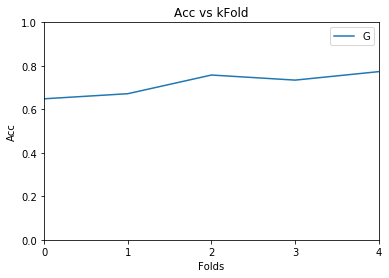

In [87]:
graphic_data([0,1,2,3,4],data,("GRU w2v50"),'Acc vs kFold', 'Folds', 'Acc',0,0,4,1)

#### Parte Validación: variando valor de units, w2v50, GRU

In [88]:
acc_final_w2v50 = []
score_final_w2v50 = []
history_final_w2v50 = []
models_w2v50 = []
perform_final_validation(Xw2v50, Yw2v50, X_1w2v50, Y_1w2v50, w2v50_emb_size)
score_final_w2v50,acc_final_w2v50,history_final_w2v50,models_w2v50 = perform_final_validation(Xw2v50, Yw2v50,
                                                                                X_1w2v50, Y_1w2v50, w2v50_emb_size,
                                                                                              units_final,epochs,0)

########################
## UNIT SIZE  8
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 36, 8)             1888      
_________________________________________________________________
lstm_34 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dropout_17 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 36        
_________________________________________________________________
activation_17 (Activation)   (None, 4)                 0         
Total params: 2,468
Trainable params: 2,468
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
640/640 [==============================] - 2s 4ms/step - loss: 1

640/640 [==============================] - 0s 669us/step - loss: 0.7117 - accuracy: 0.7063
Epoch 70/200
640/640 [==============================] - 0s 623us/step - loss: 0.6748 - accuracy: 0.7453
Epoch 71/200
640/640 [==============================] - 0s 520us/step - loss: 0.6613 - accuracy: 0.7484
Epoch 72/200
640/640 [==============================] - 0s 537us/step - loss: 0.6839 - accuracy: 0.7281
Epoch 73/200
640/640 [==============================] - 0s 495us/step - loss: 0.6814 - accuracy: 0.7453
Epoch 74/200
640/640 [==============================] - 0s 603us/step - loss: 0.6577 - accuracy: 0.7516
Epoch 75/200
640/640 [==============================] - 0s 662us/step - loss: 0.6570 - accuracy: 0.7312
Epoch 76/200
640/640 [==============================] - 0s 586us/step - loss: 0.6745 - accuracy: 0.7312
Epoch 77/200
640/640 [==============================] - 0s 627us/step - loss: 0.6571 - accuracy: 0.7312
Epoch 78/200
640/640 [==============================] - 0s 608us/step - loss:

640/640 [==============================] - 0s 626us/step - loss: 0.4732 - accuracy: 0.8484
Epoch 148/200
640/640 [==============================] - 0s 597us/step - loss: 0.4535 - accuracy: 0.8547
Epoch 149/200
640/640 [==============================] - 0s 505us/step - loss: 0.4742 - accuracy: 0.8547
Epoch 150/200
640/640 [==============================] - 0s 547us/step - loss: 0.4742 - accuracy: 0.8531
Epoch 151/200
640/640 [==============================] - 0s 737us/step - loss: 0.4633 - accuracy: 0.8594
Epoch 152/200
640/640 [==============================] - 0s 553us/step - loss: 0.4368 - accuracy: 0.8750
Epoch 153/200
640/640 [==============================] - 0s 581us/step - loss: 0.4713 - accuracy: 0.8609
Epoch 154/200
640/640 [==============================] - 0s 648us/step - loss: 0.4556 - accuracy: 0.8719
Epoch 155/200
640/640 [==============================] - 0s 531us/step - loss: 0.4629 - accuracy: 0.8594
Epoch 156/200
640/640 [==============================] - 0s 746us/ste

640/640 [==============================] - 0s 640us/step - loss: 1.1698 - accuracy: 0.4781
Epoch 15/200
640/640 [==============================] - 0s 646us/step - loss: 1.1467 - accuracy: 0.4953
Epoch 16/200
640/640 [==============================] - 0s 606us/step - loss: 1.1081 - accuracy: 0.5219
Epoch 17/200
640/640 [==============================] - 0s 607us/step - loss: 1.0712 - accuracy: 0.5375
Epoch 18/200
640/640 [==============================] - 0s 595us/step - loss: 1.0297 - accuracy: 0.5656
Epoch 19/200
640/640 [==============================] - 0s 584us/step - loss: 0.9943 - accuracy: 0.5844
Epoch 20/200
640/640 [==============================] - 0s 628us/step - loss: 0.9538 - accuracy: 0.5859
Epoch 21/200
640/640 [==============================] - 0s 615us/step - loss: 0.9286 - accuracy: 0.6266
Epoch 22/200
640/640 [==============================] - 0s 728us/step - loss: 0.9064 - accuracy: 0.6500
Epoch 23/200
640/640 [==============================] - 0s 662us/step - loss:

640/640 [==============================] - 0s 559us/step - loss: 0.2434 - accuracy: 0.9406
Epoch 93/200
640/640 [==============================] - 0s 544us/step - loss: 0.2344 - accuracy: 0.9438
Epoch 94/200
640/640 [==============================] - 0s 565us/step - loss: 0.2406 - accuracy: 0.9453
Epoch 95/200
640/640 [==============================] - 0s 545us/step - loss: 0.2424 - accuracy: 0.9500
Epoch 96/200
640/640 [==============================] - 0s 569us/step - loss: 0.2197 - accuracy: 0.9469
Epoch 97/200
640/640 [==============================] - 0s 603us/step - loss: 0.2343 - accuracy: 0.9469
Epoch 98/200
640/640 [==============================] - 0s 616us/step - loss: 0.2164 - accuracy: 0.9469
Epoch 99/200
640/640 [==============================] - 0s 578us/step - loss: 0.1948 - accuracy: 0.9516
Epoch 100/200
640/640 [==============================] - 0s 679us/step - loss: 0.2003 - accuracy: 0.9516
Epoch 101/200
640/640 [==============================] - 0s 535us/step - los

640/640 [==============================] - 0s 720us/step - loss: 0.2651 - accuracy: 0.9297
Epoch 171/200
640/640 [==============================] - 0s 640us/step - loss: 0.2965 - accuracy: 0.9250
Epoch 172/200
640/640 [==============================] - 0s 670us/step - loss: 0.2764 - accuracy: 0.9297
Epoch 173/200
640/640 [==============================] - 0s 738us/step - loss: 0.2230 - accuracy: 0.9438
Epoch 174/200
640/640 [==============================] - 0s 620us/step - loss: 0.2446 - accuracy: 0.9438
Epoch 175/200
640/640 [==============================] - 0s 632us/step - loss: 0.2269 - accuracy: 0.9500
Epoch 176/200
640/640 [==============================] - 0s 614us/step - loss: 0.2102 - accuracy: 0.9484
Epoch 177/200
640/640 [==============================] - 0s 619us/step - loss: 0.2198 - accuracy: 0.9531
Epoch 178/200
640/640 [==============================] - 0s 593us/step - loss: 0.2064 - accuracy: 0.9547
Epoch 179/200
640/640 [==============================] - 0s 670us/ste

640/640 [==============================] - 0s 769us/step - loss: 0.2415 - accuracy: 0.9359
Epoch 39/200
640/640 [==============================] - 1s 834us/step - loss: 0.2500 - accuracy: 0.9312
Epoch 40/200
640/640 [==============================] - 1s 808us/step - loss: 0.2359 - accuracy: 0.9281
Epoch 41/200
640/640 [==============================] - 0s 732us/step - loss: 0.2566 - accuracy: 0.9203
Epoch 42/200
640/640 [==============================] - 0s 777us/step - loss: 0.2142 - accuracy: 0.9344
Epoch 43/200
640/640 [==============================] - 1s 788us/step - loss: 0.2471 - accuracy: 0.9250
Epoch 44/200
640/640 [==============================] - 1s 831us/step - loss: 0.2265 - accuracy: 0.9312
Epoch 45/200
640/640 [==============================] - 1s 824us/step - loss: 0.2085 - accuracy: 0.9453
Epoch 46/200
640/640 [==============================] - 0s 754us/step - loss: 0.1862 - accuracy: 0.9453
Epoch 47/200
640/640 [==============================] - 1s 788us/step - loss:

640/640 [==============================] - 1s 850us/step - loss: 0.0542 - accuracy: 0.9891
Epoch 117/200
640/640 [==============================] - 1s 812us/step - loss: 0.0520 - accuracy: 0.9922
Epoch 118/200
640/640 [==============================] - 0s 765us/step - loss: 0.0392 - accuracy: 0.9922
Epoch 119/200
640/640 [==============================] - 0s 747us/step - loss: 0.0518 - accuracy: 0.9891
Epoch 120/200
640/640 [==============================] - 0s 745us/step - loss: 0.0433 - accuracy: 0.9875
Epoch 121/200
640/640 [==============================] - 0s 723us/step - loss: 0.0433 - accuracy: 0.9922
Epoch 122/200
640/640 [==============================] - 0s 774us/step - loss: 0.0391 - accuracy: 0.9922
Epoch 123/200
640/640 [==============================] - 0s 697us/step - loss: 0.0440 - accuracy: 0.9922
Epoch 124/200
640/640 [==============================] - 0s 746us/step - loss: 0.0400 - accuracy: 0.9922
Epoch 125/200
640/640 [==============================] - 1s 833us/ste

640/640 [==============================] - 1s 1ms/step - loss: 0.0271 - accuracy: 0.9937
Epoch 195/200
640/640 [==============================] - 1s 930us/step - loss: 0.0297 - accuracy: 0.9953
Epoch 196/200
640/640 [==============================] - 1s 960us/step - loss: 0.0245 - accuracy: 0.9953
Epoch 197/200
640/640 [==============================] - 1s 838us/step - loss: 0.0245 - accuracy: 0.9937
Epoch 198/200
640/640 [==============================] - 1s 850us/step - loss: 0.0257 - accuracy: 0.9953
Epoch 199/200
640/640 [==============================] - 1s 817us/step - loss: 0.0246 - accuracy: 0.9953
Epoch 200/200
113/113 [==============================] - 1s 10ms/step
########################
## UNIT SIZE  64
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 36, 64)            29440     
_____________________________________________________

640/640 [==============================] - 1s 1ms/step - loss: 0.2067 - accuracy: 0.9344
Epoch 64/200
640/640 [==============================] - 1s 1ms/step - loss: 0.1945 - accuracy: 0.9359
Epoch 65/200
640/640 [==============================] - 1s 1ms/step - loss: 0.1392 - accuracy: 0.9578
Epoch 66/200
640/640 [==============================] - 1s 1ms/step - loss: 0.1144 - accuracy: 0.9766
Epoch 67/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0786 - accuracy: 0.9844
Epoch 68/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0756 - accuracy: 0.9859
Epoch 69/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0661 - accuracy: 0.9859
Epoch 70/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0539 - accuracy: 0.9875
Epoch 71/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0507 - accuracy: 0.9906
Epoch 72/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0477 - accuracy: 

640/640 [==============================] - 1s 1ms/step - loss: 0.0700 - accuracy: 0.9875
Epoch 144/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0428 - accuracy: 0.9906
Epoch 145/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0711 - accuracy: 0.9859
Epoch 146/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0653 - accuracy: 0.9875
Epoch 147/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0609 - accuracy: 0.9875
Epoch 148/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0475 - accuracy: 0.9875
Epoch 149/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0533 - accuracy: 0.9922
Epoch 150/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0483 - accuracy: 0.9922
Epoch 151/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0583 - accuracy: 0.9906
Epoch 152/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0486 - a

640/640 [==============================] - 2s 2ms/step - loss: 0.4247 - accuracy: 0.8484
Epoch 12/200
640/640 [==============================] - 2s 3ms/step - loss: 0.3751 - accuracy: 0.8672
Epoch 13/200
640/640 [==============================] - 2s 3ms/step - loss: 0.3210 - accuracy: 0.8891
Epoch 14/200
640/640 [==============================] - 2s 3ms/step - loss: 0.2964 - accuracy: 0.8938
Epoch 15/200
640/640 [==============================] - 2s 3ms/step - loss: 0.2835 - accuracy: 0.9016
Epoch 16/200
640/640 [==============================] - 1s 2ms/step - loss: 0.2563 - accuracy: 0.9078
Epoch 17/200
640/640 [==============================] - 1s 2ms/step - loss: 0.2647 - accuracy: 0.9187
Epoch 18/200
640/640 [==============================] - 2s 3ms/step - loss: 0.2495 - accuracy: 0.9062
Epoch 19/200
640/640 [==============================] - 2s 3ms/step - loss: 0.2298 - accuracy: 0.9281
Epoch 20/200
640/640 [==============================] - 2s 3ms/step - loss: 0.2063 - accuracy: 

640/640 [==============================] - 2s 3ms/step - loss: 0.0506 - accuracy: 0.9906
Epoch 92/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0339 - accuracy: 0.9922
Epoch 93/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0273 - accuracy: 0.9953
Epoch 94/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0548 - accuracy: 0.9844
Epoch 95/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0243 - accuracy: 0.9953
Epoch 96/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0137 - accuracy: 0.9969
Epoch 97/200
640/640 [==============================] - 2s 2ms/step - loss: 0.0119 - accuracy: 0.9969
Epoch 98/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0061 - accuracy: 1.0000
Epoch 99/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 100/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0031 - accuracy:

640/640 [==============================] - 2s 2ms/step - loss: 2.8113e-04 - accuracy: 1.0000
Epoch 169/200
640/640 [==============================] - 2s 3ms/step - loss: 3.0133e-04 - accuracy: 1.0000
Epoch 170/200
640/640 [==============================] - 2s 3ms/step - loss: 2.9794e-04 - accuracy: 1.0000
Epoch 171/200
640/640 [==============================] - 2s 3ms/step - loss: 2.6786e-04 - accuracy: 1.0000
Epoch 172/200
640/640 [==============================] - 2s 2ms/step - loss: 2.6615e-04 - accuracy: 1.0000
Epoch 173/200
640/640 [==============================] - 1s 2ms/step - loss: 2.4718e-04 - accuracy: 1.0000
Epoch 174/200
640/640 [==============================] - 2s 3ms/step - loss: 2.5836e-04 - accuracy: 1.0000
Epoch 175/200
640/640 [==============================] - 1s 2ms/step - loss: 2.5864e-04 - accuracy: 1.0000
Epoch 176/200
640/640 [==============================] - 2s 3ms/step - loss: 2.6439e-04 - accuracy: 1.0000
Epoch 177/200
640/640 [============================

Epoch 36/200
640/640 [==============================] - 3s 4ms/step - loss: 0.0357 - accuracy: 0.9891
Epoch 37/200
640/640 [==============================] - 3s 4ms/step - loss: 0.0194 - accuracy: 0.9953
Epoch 38/200
640/640 [==============================] - 3s 4ms/step - loss: 0.0191 - accuracy: 0.9937
Epoch 39/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0121 - accuracy: 0.9953
Epoch 40/200
640/640 [==============================] - 3s 4ms/step - loss: 0.0258 - accuracy: 0.9937
Epoch 41/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0255 - accuracy: 0.9922
Epoch 42/200
640/640 [==============================] - 2s 4ms/step - loss: 0.0447 - accuracy: 0.9875
Epoch 43/200
640/640 [==============================] - 3s 5ms/step - loss: 0.0511 - accuracy: 0.9844
Epoch 44/200
640/640 [==============================] - 2s 4ms/step - loss: 0.0497 - accuracy: 0.9828
Epoch 45/200
640/640 [==============================] - 3s 4ms/step - loss: 0.1220

640/640 [==============================] - 2s 3ms/step - loss: 2.5788e-04 - accuracy: 1.0000
Epoch 115/200
640/640 [==============================] - 2s 3ms/step - loss: 2.2896e-04 - accuracy: 1.0000
Epoch 116/200
640/640 [==============================] - 3s 4ms/step - loss: 2.1604e-04 - accuracy: 1.0000
Epoch 117/200
640/640 [==============================] - 2s 3ms/step - loss: 2.2285e-04 - accuracy: 1.0000
Epoch 118/200
640/640 [==============================] - 3s 4ms/step - loss: 2.0899e-04 - accuracy: 1.0000
Epoch 119/200
640/640 [==============================] - 3s 4ms/step - loss: 2.3779e-04 - accuracy: 1.0000
Epoch 120/200
640/640 [==============================] - 2s 4ms/step - loss: 2.1946e-04 - accuracy: 1.0000
Epoch 121/200
640/640 [==============================] - 3s 4ms/step - loss: 2.1220e-04 - accuracy: 1.0000
Epoch 122/200
640/640 [==============================] - 3s 5ms/step - loss: 2.0867e-04 - accuracy: 1.0000
Epoch 123/200
640/640 [============================

640/640 [==============================] - 3s 5ms/step - loss: 9.6058e-05 - accuracy: 1.0000
Epoch 191/200
640/640 [==============================] - 4s 5ms/step - loss: 8.7519e-05 - accuracy: 1.0000
Epoch 192/200
640/640 [==============================] - 3s 4ms/step - loss: 8.0592e-05 - accuracy: 1.0000
Epoch 193/200
640/640 [==============================] - 3s 4ms/step - loss: 8.6111e-05 - accuracy: 1.0000
Epoch 194/200
640/640 [==============================] - 2s 4ms/step - loss: 8.1336e-05 - accuracy: 1.0000
Epoch 195/200
640/640 [==============================] - 3s 4ms/step - loss: 8.4857e-05 - accuracy: 1.0000
Epoch 196/200
640/640 [==============================] - 4s 6ms/step - loss: 8.3130e-05 - accuracy: 1.0000
Epoch 197/200
640/640 [==============================] - 2s 4ms/step - loss: 9.6165e-05 - accuracy: 1.0000
Epoch 198/200
640/640 [==============================] - 4s 6ms/step - loss: 7.6924e-05 - accuracy: 1.0000
Epoch 199/200
640/640 [============================

#### Parte  Gráficos: variando valor de units, w2v50, LSTM

In [89]:
#Preparando los datos para graficar
data_final_acc_w2v50 = []
data_final_loss_w2v50 = []


for i in np.arange(0,len(units_final)):
    data_final_acc_w2v50.append(history_final_w2v50[i].history['accuracy'])

for i in np.arange(0,len(units_final)):
    data_final_loss_w2v50.append(history_final_w2v50[i].history['loss'])
   

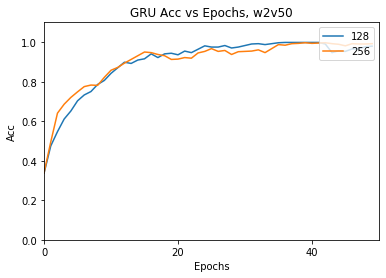

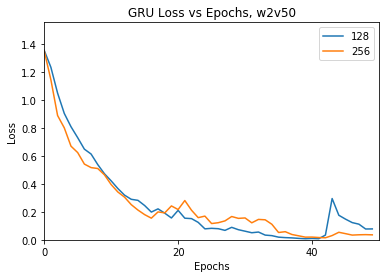

In [90]:
##Gráfico de Accuracy
graphic_data(np.arange(0,epochs,20),data_final_acc_w2v50,units_final,'GRU Acc vs Epochs, w2v50', 'Epochs', 'Acc',0,0,epochs,1+0.1)

##Gráfico de Loss 
max_loss_w2v50 = 0
for i in np.arange(0,len(data_final_loss_w2v50)):
    if(max(data_final_loss_w2v50[i]) > max_loss_w2v50):
        max_loss_w2v50 = max(data_final_loss_w2v50[i])
graphic_data(np.arange(0,epochs,20),data_final_loss_w2v50,units_final,'GRU Loss vs Epochs, w2v50', 'Epochs', 'Loss',
             0,0,epochs,max_loss_w2v50+0.2)

### Predicción: Modelo w2v50, LSTM

In [91]:
def predict_all_models(X_real, Y_real, models):
    j = 0
    all_predict = []
    counter_true =  collections.Counter(Y_real.argmax(1))
    for i in units_final:
        print("##### Predict, Units ", i,"#####")
        Y_predict_i=models[j].predict(X_real)
        counter_pred_i = collections.Counter(Y_predict_i.argmax(1))
        all_predict.append(Y_predict_i)
        print("predict: ",list(counter_pred_i.values()))
        print("Real   : ",list(counter_true.values()))
        j = j + 1
    return all_predict

In [92]:
all_predict_w2v50 = []
all_predict_w2v50 = predict_all_models(Xw2v50_full,Yw2v50_full,models_w2v50)

##### Predict, Units  128 #####
predict:  [199, 178, 172, 204]
Real   :  [188, 180, 180, 205]
##### Predict, Units  256 #####
predict:  [193, 188, 170, 202]
Real   :  [188, 180, 180, 205]


In [93]:
i = 0
for j in units_final:
    print("Units:", j, " - RMSE GRU w2v50:  ",mean_squared_error(Yw2v50_full, all_predict_w2v50[i])) #Y_true, Y_predict
    i = i + 1

Units: 128  - RMSE GRU w2v50:   0.024969066
Units: 256  - RMSE GRU w2v50:   0.020274747


#### Matriz Confusión: w2v50

Confusion matrix, without normalization
Confusion matrix, without normalization


<Figure size 360x360 with 0 Axes>

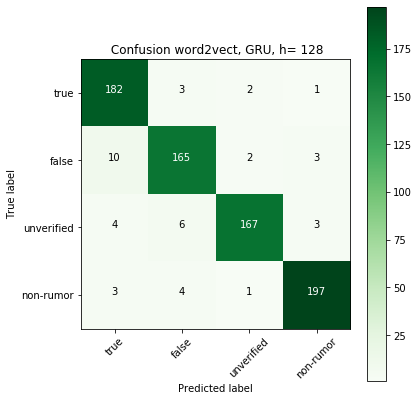

<Figure size 360x360 with 0 Axes>

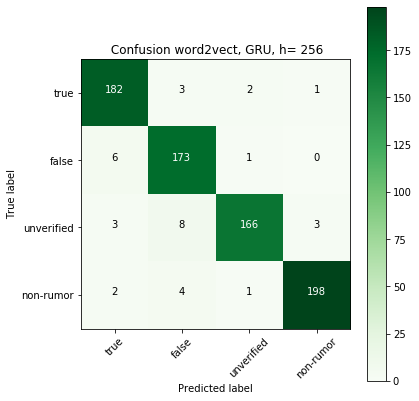

In [94]:
j = 0
for i in units_final:
    plot_conf_matrix(Yw2v50_full, all_predict_w2v50[j]," Confusion word2vect, GRU, h= " + str(i))
    j = j +1